<a href="https://colab.research.google.com/github/hyulianton/JaringanSyarafTiruan/blob/main/jst_%F0%9F%92%BB_Implementasi_Tiga_Optimizer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 💻 Implementasi Tiga Optimizer (SGD, RMSProp, Adam) pada MNIST

### Cell 1: Persiapan Lingkungan dan Impor Pustaka

Ini adalah langkah awal untuk memastikan semua yang dibutuhkan sudah tersedia dan diimpor.

In [1]:
# ===============================================
# CELL 1: Setup dan Impor Pustaka
# ===============================================

# Impor pustaka utama PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init # Untuk inisialisasi bobot yang seragam

# Impor pustaka untuk dataset dan dataloader
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Pustaka untuk visualisasi dan manipulasi data
import matplotlib.pyplot as plt
import copy # Untuk menyalin model

### Cell 2: Konfigurasi, Persiapan Data MNIST, dan Model MLP

Di sini kita definisikan *hyperparameter*, *dataloader* untuk dataset MNIST, dan arsitektur model **Multilayer Perceptron (MLP)** sederhana.

In [2]:
# ===============================================
# CELL 2: Konfigurasi, Data, dan Model
# ===============================================

# Hyperparameter global
EPOCHS = 15                 # Jumlah siklus pelatihan penuh (epoch)
BATCH_SIZE = 64             # Jumlah sampel per iterasi (Mini-Batch)
LEARNING_RATE_SGD = 0.01    # Learning Rate untuk SGD (biasanya sedikit lebih tinggi)
LEARNING_RATE_ADAPTIVE = 0.001 # Learning Rate standar untuk RMSProp dan Adam
MOMENTUM = 0.9              # Koefisien momentum
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu") # Gunakan GPU jika tersedia

# Transformasi Data: Ubah gambar ke tensor dan normalisasi
transform = transforms.Compose([
    transforms.ToTensor(), # Konversi citra PIL ke Tensor
    transforms.Normalize((0.1307,), (0.3081,)) # Normalisasi standar MNIST
])

# Download dan Muat Dataset MNIST
train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('./data', train=False, transform=transform)

# DataLoader: Memuat data dalam batch
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Definisi Model MLP Sederhana
class SimpleMLP(nn.Module):
    def __init__(self):
        super(SimpleMLP, self).__init__()
        # 28*28 = 784 input fitur (gambar MNIST)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(28*28, 512)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(512, 10) # 10 output (kelas 0-9)

    def forward(self, x):
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        logits = self.fc2(x)
        return logits

# Fungsi untuk inisialisasi bobot yang seragam
def init_weights(m):
    if type(m) == nn.Linear:
        init.kaiming_uniform_(m.weight) # Inisialisasi yang direkomendasikan untuk ReLU
        m.bias.data.fill_(0.01)

# Inisialisasi Model Awal
initial_model = SimpleMLP().to(DEVICE)
initial_model.apply(init_weights)

100%|██████████| 9.91M/9.91M [00:00<00:00, 20.0MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 479kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.46MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 3.93MB/s]


SimpleMLP(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=512, out_features=10, bias=True)
)

### Cell 3: Inisialisasi dan Konfigurasi Tiga Optimizer

Kita akan membuat tiga model terpisah, tetapi **semuanya diinisialisasi dengan bobot yang sama**. Ini kunci agar perbandingan bersifat adil (*fair comparison*).

In [3]:
# ===============================================
# CELL 3: Inisialisasi Model dan Optimizer
# ===============================================

# Menyalin model awal (memastikan semua model punya bobot awal yang identik)
model_sgd = copy.deepcopy(initial_model)
model_rms = copy.deepcopy(initial_model)
model_adam = copy.deepcopy(initial_model)

# Fungsi Kerugian (Loss Function)
criterion = nn.CrossEntropyLoss()

# 1. Optimizer SGD dengan Momentum
optimizer_sgd = optim.SGD(
    model_sgd.parameters(),
    lr=LEARNING_RATE_SGD,
    momentum=MOMENTUM # Mengaktifkan Momentum
)

# 2. Optimizer RMSProp
optimizer_rms = optim.RMSprop(
    model_rms.parameters(),
    lr=LEARNING_RATE_ADAPTIVE # Menggunakan LR adaptif yang lebih kecil
)

# 3. Optimizer Adam
optimizer_adam = optim.Adam(
    model_adam.parameters(),
    lr=LEARNING_RATE_ADAPTIVE # Menggunakan LR adaptif yang lebih kecil
)

# Daftar untuk menyimpan histori Loss/Akurasi
history = {
    'sgd_loss': [], 'sgd_acc': [],
    'rms_loss': [], 'rms_acc': [],
    'adam_loss': [], 'adam_acc': []
}

### Cell 4: Fungsi Pelatihan (Training Loop)

Fungsi inti yang menjalankan pelatihan satu *epoch* untuk setiap model secara paralel.

In [4]:
# ===============================================
# CELL 4: Fungsi Training
# ===============================================

def train_model(model, optimizer, loader, loss_list, acc_list, label):
    """Melatih model untuk satu epoch dan mencatat hasilnya"""
    model.train() # Mengatur model ke mode pelatihan
    total_loss = 0
    correct = 0

    for batch_idx, (data, target) in enumerate(loader):
        data, target = data.to(DEVICE), target.to(DEVICE) # Pindahkan data ke DEVICE (GPU/CPU)

        optimizer.zero_grad()      # 1. Nolkan gradien dari iterasi sebelumnya
        output = model(data)       # 2. Forward pass: hitung prediksi
        loss = criterion(output, target) # 3. Hitung Loss
        loss.backward()            # 4. Backward pass: hitung gradien
        optimizer.step()           # 5. Update bobot (Langkah optimisasi)

        total_loss += loss.item() # Akumulasi total loss

        # Hitung Akurasi Batch
        pred = output.argmax(dim=1, keepdim=True) # Dapatkan indeks kelas terbesar
        correct += pred.eq(target.view_as(pred)).sum().item()

    avg_loss = total_loss / len(loader)
    avg_acc = 100. * correct / len(loader.dataset)

    loss_list.append(avg_loss)
    acc_list.append(avg_acc)
    print(f"  {label} | Loss: {avg_loss:.4f} | Acc: {avg_acc:.2f}%")

### Cell 5: Eksekusi Pelatihan dan Komparasi

Menjalankan semua model untuk perbandingan dan mencetak hasilnya di setiap *epoch*.

In [5]:
# ===============================================
# CELL 5: Eksekusi Pelatihan
# ===============================================

print(f"Memulai Komparasi {EPOCHS} Epoch pada DEVICE: {DEVICE}")
print("==================================================")

for epoch in range(1, EPOCHS + 1):
    print(f"\n--- EPOCH {epoch}/{EPOCHS} ---")

    # Latih SGD
    train_model(model_sgd, optimizer_sgd, train_loader, history['sgd_loss'], history['sgd_acc'], "SGD")

    # Latih RMSProp
    train_model(model_rms, optimizer_rms, train_loader, history['rms_loss'], history['rms_acc'], "RMSProp")

    # Latih Adam
    train_model(model_adam, optimizer_adam, train_loader, history['adam_loss'], history['adam_acc'], "ADAM")

print("\n==================================================")
print("Pelatihan Selesai. Hasil Komparasi ada di Histori.")

Memulai Komparasi 15 Epoch pada DEVICE: cuda

--- EPOCH 1/15 ---
  SGD | Loss: 0.2170 | Acc: 93.49%
  RMSProp | Loss: 0.2294 | Acc: 93.88%
  ADAM | Loss: 0.1987 | Acc: 94.05%

--- EPOCH 2/15 ---
  SGD | Loss: 0.0877 | Acc: 97.47%
  RMSProp | Loss: 0.0865 | Acc: 97.25%
  ADAM | Loss: 0.0820 | Acc: 97.39%

--- EPOCH 3/15 ---
  SGD | Loss: 0.0565 | Acc: 98.33%
  RMSProp | Loss: 0.0566 | Acc: 98.17%
  ADAM | Loss: 0.0544 | Acc: 98.28%

--- EPOCH 4/15 ---
  SGD | Loss: 0.0390 | Acc: 98.90%
  RMSProp | Loss: 0.0428 | Acc: 98.62%
  ADAM | Loss: 0.0443 | Acc: 98.51%

--- EPOCH 5/15 ---
  SGD | Loss: 0.0277 | Acc: 99.29%
  RMSProp | Loss: 0.0331 | Acc: 98.92%
  ADAM | Loss: 0.0322 | Acc: 98.92%

--- EPOCH 6/15 ---
  SGD | Loss: 0.0195 | Acc: 99.56%
  RMSProp | Loss: 0.0270 | Acc: 99.12%
  ADAM | Loss: 0.0269 | Acc: 99.08%

--- EPOCH 7/15 ---
  SGD | Loss: 0.0142 | Acc: 99.74%
  RMSProp | Loss: 0.0236 | Acc: 99.21%
  ADAM | Loss: 0.0256 | Acc: 99.12%

--- EPOCH 8/15 ---
  SGD | Loss: 0.0104 | Ac

### Cell 6: Visualisasi Hasil Eksperimen

Langkah terakhir dan paling penting: visualisasi untuk membandingkan kurva *Loss* dan *Akurasi* secara langsung.

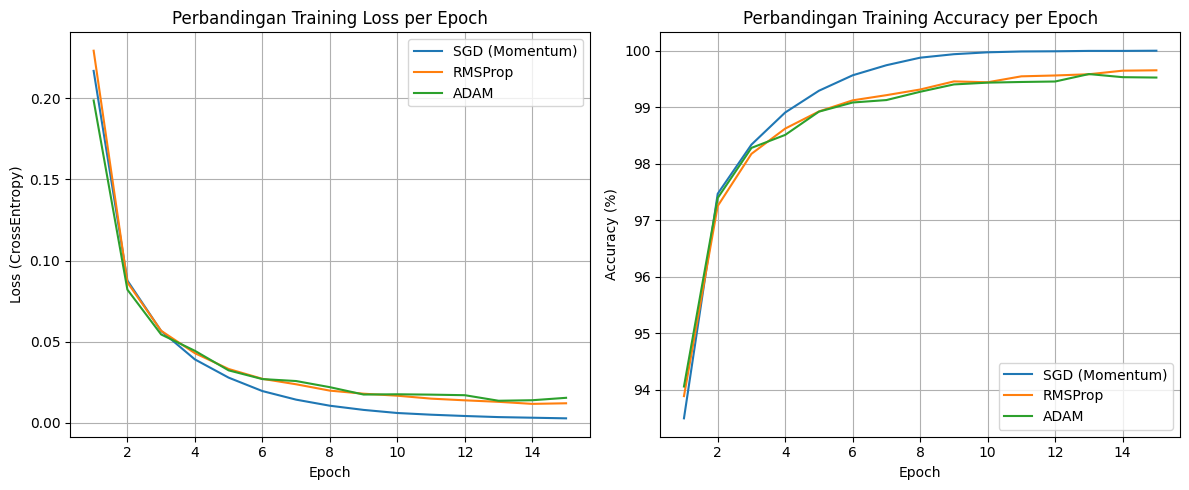


--- Akurasi Akhir (Epoch Terakhir) ---
SGD Akurasi: 100.00%
RMSProp Akurasi: 99.65%
ADAM Akurasi: 99.52%


In [6]:
# ===============================================
# CELL 6: Visualisasi Hasil
# ===============================================

epochs_range = range(1, EPOCHS + 1)

# --- 1. Plot Kurva Loss ---
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1) # Plot di bagian kiri
plt.plot(epochs_range, history['sgd_loss'], label='SGD (Momentum)')
plt.plot(epochs_range, history['rms_loss'], label='RMSProp')
plt.plot(epochs_range, history['adam_loss'], label='ADAM')
plt.title('Perbandingan Training Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss (CrossEntropy)')
plt.legend()
plt.grid(True)

# --- 2. Plot Kurva Akurasi ---
plt.subplot(1, 2, 2) # Plot di bagian kanan
plt.plot(epochs_range, history['sgd_acc'], label='SGD (Momentum)')
plt.plot(epochs_range, history['rms_acc'], label='RMSProp')
plt.plot(epochs_range, history['adam_acc'], label='ADAM')
plt.title('Perbandingan Training Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)

plt.tight_layout() # Penyesuaian tata letak
plt.show()

# Hasil Akhir (Akurasi Terakhir)
print("\n--- Akurasi Akhir (Epoch Terakhir) ---")
print(f"SGD Akurasi: {history['sgd_acc'][-1]:.2f}%")
print(f"RMSProp Akurasi: {history['rms_acc'][-1]:.2f}%")
print(f"ADAM Akurasi: {history['adam_acc'][-1]:.2f}%")

**Ekspektasi Hasil Visualisasi:**

Anda akan melihat kurva **ADAM** dan **RMSProp** cenderung turun paling cepat di awal, menunjukkan konvergensi awal yang superior. Kurva **SGD** mungkin sedikit lebih lambat, tetapi berpotensi menyamai atau bahkan melampaui yang lain pada *epoch* akhir, asalkan *learning rate*-nya di-*tuning* dengan baik. Visualisasi ini membuktikan secara empiris perbedaan teoretis dari ketiga *optimizer* tersebut